# Movie Recommendation System CPU

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import time
import requests
from bs4 import BeautifulSoup
from sklearn.svm import SVR
from numba import cuda
import cupy as cp
import helper_cpu as hpcpu
import helper_contingency as hpc

## Data Exploration and Description

In [2]:
query=pd.read_csv("~/Downloads/ml-100k/u.data",header=None,delimiter="\t",names=["user id", "item id","rating","timestamp"])
genre=pd.read_csv("~/Downloads/ml-100k/u.genre",header=None,delimiter="|")
user=pd.read_csv("~/Downloads/ml-100k/u.user",header=None,delimiter="|")
item=pd.read_csv("~/Downloads/ml-100k/u.item",header=None,delimiter="|",encoding='ISO-8859-1')

### Analysing Item

In [3]:
with pd.option_context("display.max.rows",4,"display.max.columns",8):
    print(item)

        0                                          1            2   3   ...  \
0        1                           Toy Story (1995)  01-Jan-1995 NaN  ...   
1        2                           GoldenEye (1995)  01-Jan-1995 NaN  ...   
...    ...                                        ...          ...  ..  ...   
1680  1681                        You So Crazy (1994)  01-Jan-1994 NaN  ...   
1681  1682  Scream of Stone (Schrei aus Stein) (1991)  08-Mar-1996 NaN  ...   

     20  21  22  23  
0     0   0   0   0  
1     0   1   0   0  
...  ..  ..  ..  ..  
1680  0   0   0   0  
1681  0   0   0   0  

[1682 rows x 24 columns]


In [4]:
item[2]=pd.to_datetime(item[2])
with pd.option_context("display.max.rows",10,"display.max.columns",10):
    print(item[item[0]==267])

      0        1   2   3    4   ...  19  20  21  22  23
266  267  unknown NaT NaN  NaN  ...   0   0   0   0   0

[1 rows x 24 columns]


In [5]:
with pd.option_context("display.max.rows",10,"display.max.columns",10):
    print(query[query["item id"]==267])

       user id  item id  rating  timestamp
2172       130      267       5  875801239
3781         5      267       4  875635064
7245       268      267       3  875742077
12475      297      267       3  875409139
14756      319      267       4  875707690
15292        1      267       4  875692955
49295      532      267       3  875441348
93523      833      267       1  875655669
99723      422      267       4  875655986


In [6]:
item.iloc[266,2]=pd.to_datetime("1997-09-28")
item.drop([1,3,4],axis=1,inplace=True)
item[2]=item[2].apply(lambda x: datetime.timestamp(x))

In [7]:
with pd.option_context("display.max.rows",4,"display.max.columns",10):
    print(item)

        0            2   5   6   7   ...  19  20  21  22  23
0        1  788898600.0   0   0   0  ...   0   0   0   0   0
1        2  788898600.0   0   1   1  ...   0   0   1   0   0
...    ...          ...  ..  ..  ..  ...  ..  ..  ..  ..  ..
1680  1681  757362600.0   0   0   0  ...   0   0   0   0   0
1681  1682  826223400.0   0   0   0  ...   0   0   0   0   0

[1682 rows x 21 columns]


In [8]:
item=pd.read_csv("~/Downloads/ml-100k/item_final.csv")

In [9]:
item

,0,2,5,6,7,8,9,10,11,12,...,14,15,16,17,18,19,20,21,22,23
0,1,788898600.0,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,788898600.0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,788898600.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,788898600.0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,788898600.0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,886703400.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,886703400.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,883593000.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,757362600.0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Analysis of query

In [10]:
with pd.option_context("display.max.rows",4,"display.max.columns",10):
    print(query)

       user id  item id  rating  timestamp
0          196      242       3  881250949
1          186      302       3  891717742
...        ...      ...     ...        ...
99998       13      225       2  882399156
99999       12      203       3  879959583

[100000 rows x 4 columns]


In [11]:
a=[]
for i in range(len(query)):
    a.append(query.iloc[i,3]-item.iloc[query.iloc[i,1]-1,1])
    
query["lapse"]=a
del a
with pd.option_context("display.max.rows",10,"display.max.columns",10):
    print(query)

       user id  item id  rating  timestamp        lapse
0          196      242       3  881250949   27206749.0
1          186      302       3  891717742   39660742.0
2           22      377       1  878887116  121524516.0
3          244       51       2  880606923  123244323.0
4          166      346       1  886397596   34340596.0
...        ...      ...     ...        ...          ...
99995      880      476       3  880175444   37536044.0
99996      716      204       5  879795543  406429743.0
99997      276     1090       1  874795795  148969195.0
99998       13      225       2  882399156   33366156.0
99999       12      203       3  879959583  185755383.0

[100000 rows x 5 columns]


In [12]:
A=cp.zeros((943,1682))
B=cp.asarray(query.iloc[:,0].values)

C=cp.asarray(query.iloc[:,1].values)

D=cp.asarray(query.iloc[:,2].values)

@cuda.jit
def rating_func(A,B,C,D):
    row=cuda.grid(1)
    if row<len(B):
        A[B[row]-1,C[row]-1]=D[row]

rating_func[200,500](A,B,C,D)

rating=cp.asnumpy(A)

del A,B,C,D

rating

array([[5., 3., 4., ..., 0., 0., 0.],
       [4., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.]])

### Analysing User

In [13]:
with pd.option_context("display.max.rows",10,"display.max.columns",10):
    print(user)

       0   1  2              3      4
0      1  24  M     technician  85711
1      2  53  F          other  94043
2      3  23  M         writer  32067
3      4  24  M     technician  43537
4      5  33  F          other  15213
..   ...  .. ..            ...    ...
938  939  26  F        student  33319
939  940  32  M  administrator  02215
940  941  20  M        student  97229
941  942  48  F      librarian  78209
942  943  22  M        student  77841

[943 rows x 5 columns]


In [14]:
user=pd.read_csv("~/Downloads/ml-100k/user_full.csv",header=None)
with pd.option_context("display.max.rows",4,"display.max.columns",10):
    print(user)

       0      1  2           3      4           5
0      1  20-25  M  technician  85711     Arizona
1      2  50-55  F       other  94043  California
..   ...    ... ..         ...    ...         ...
941  942  45-50  F   librarian  78209       Texas
942  943  20-25  M     student  77841       Texas

[943 rows x 6 columns]


### Weight according to Movie Age

Text(0, 0.5, 'no. of ratings')

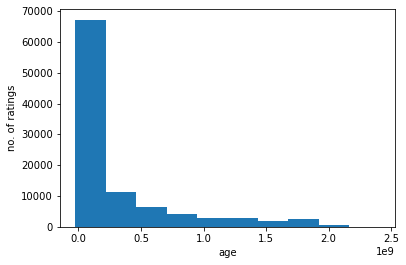

In [15]:
X=query.copy()
X.sort_values(by="timestamp",inplace=True,ascending=False)
plt.hist(X["lapse"]);
plt.xlabel("age")
plt.ylabel("no. of ratings")

In [16]:
#GPU Code
A=cp.zeros((len(X),78))
B=cp.asarray(X["timestamp"].values)
C=cp.asarray(item["2"].values)
@cuda.jit
def movie_pop(A,B,C):
    row,column=cuda.grid(2)
    if row<A.shape[0] and column<78:
        A[row,column]=counter(C,B[row],column)
        
        
@cuda.jit(device=True)
def counter(Y,x,i):
    count=0
    if i==0:
        for y in Y:
        #print(i,y)
            if (x-y)<0 and y<=(x+31536000):
                count=count+1
    else:
        for y in Y:
            #print(i,y)
            if (x-y)>=0 and int((x-y)/31536000)+1==i and y<=(x+31536000):
                count=count+1
        return(count)
    
    
movie_pop[(6250,5),(16,16)](A,B,C)
movie_pop_time=np.transpose(cp.asnumpy(A))
del A,B,C
change_loc=[0]
for i in range(100000):
    if i !=0:
        if np.array_equal(movie_pop_time[:,i],movie_pop_time[:,i-1],\
            equal_nan=False)==False:
            change_loc.append(i-1)

In [17]:
length=0
loc=0
for i in range(len(change_loc)-1):
    if (change_loc[i+1]-change_loc[i])>length:
        length=change_loc[i+1]-change_loc[i]
        loc=i
print(loc,length)

82 7292


In [18]:
change_loc[82],change_loc[83]

(64986, 72278)

In [19]:
movie_rating_count=[0 for i in range(78)]
for x in X["lapse"].values[64986+1:72278+1]:
    if x<0:
        movie_rating_count[0]=movie_rating_count[0]+1
    if x>=0 and int(x/31536000)<79:
        movie_rating_count[int(x/31536000)+1]=movie_rating_count[int(x/31536000)+1]+1

In [20]:
movie_age_weight=[]
for i in range(1,69):
    movie_age_weight.append(movie_rating_count[i]/movie_pop_time[i,64986+1])

Text(0, 0.5, 'p_i')

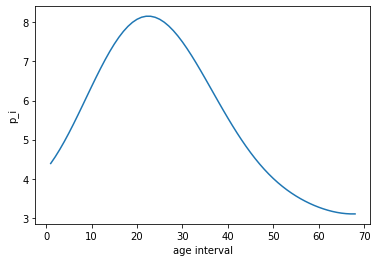

In [21]:
model=SVR(degree=10)
model.fit(np.array([i for i in range(1,69)]).reshape(-1,1),movie_age_weight[:68])
movie_age_weight_fit=model.predict(np.array([i for i in range(1,69)]).reshape(-1,1))
plt.plot([i for i in range(1,69)],movie_age_weight_fit)
plt.xlabel("age interval")
plt.ylabel("p_i")

# Collaborative Filtering

WITH NMF l2 ERROR

Factorizing Matrix---------steps: 9 error: 0.7753665387044912
Finished in 10.631644282000707 secs, error: 0.7753665387044912


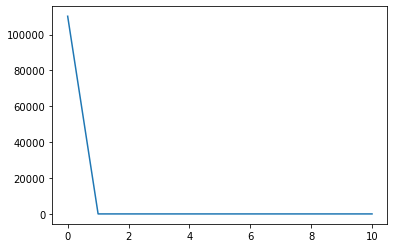

In [22]:
X=hpcpu.collaborative_filter_nmf(rating=rating,dim=30,steps=10,user_id=12,error_type="sq")

In [23]:
X=hpcpu.add_date(X,pd.DataFrame(item.iloc[:,0:2].values,columns=["item id","release"]),current_date=893286638)

In [24]:
Y=pd.merge(X,query[query["user id"]==12],how="inner",left_on="item id",right_on="item id")

In [25]:
X=hpcpu.add_weight(movie_age_weight_fit,X)

In [26]:
reco=hpcpu.recommendation(user_id=12,rank_matrix=X,query=query)
print("Movies you might want to watch",reco[0])
print("Old Movies you might want to watch",reco[1])
print("Trailers you might want to watch",reco[2])

Movies you might want to watch [1554.0, 187.0, 194.0, 654.0, 197.0, 663.0, 183.0, 357.0, 1187.0, 193.0]
Old Movies you might want to watch [675.0, 617.0, 1542.0]
Trailers you might want to watch [315.0, 1432.0]


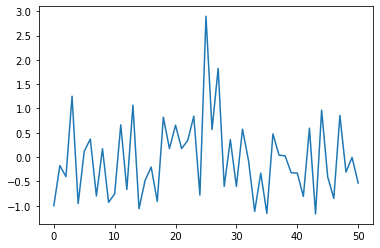

In [27]:
plt.plot(Y["score"]-Y["rating"])

WITH NMF KL ERROR

Finished in 6.71168267199937 secs 4 error: 0.13810775273884474


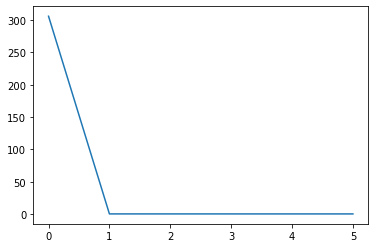

In [28]:
X=hpcpu.collaborative_filter_nmf(rating=rating,dim=30,steps=5,user_id=12,error_type="kl")

In [29]:
X=hpcpu.add_date(X,pd.DataFrame(item.iloc[:,0:2].values,columns=["item id","release"]),current_date=893286638)

In [30]:
Y=pd.merge(X,query[query["user id"]==12],how="inner",left_on="item id",right_on="item id")

In [31]:
X=hpcpu.add_weight(movie_age_weight_fit,X)

In [32]:
reco=hpcpu.recommendation(user_id=12,rank_matrix=X,query=query)
print("Movies you might want to watch",reco[0])
print("Old Movies you might want to watch",reco[1])
print("Trailers you might want to watch",reco[2])

Movies you might want to watch [1149.0, 357.0, 516.0, 530.0, 646.0, 211.0, 205.0, 428.0, 192.0, 851.0]
Old Movies you might want to watch [675.0, 617.0, 1542.0]
Trailers you might want to watch [315.0, 1432.0]


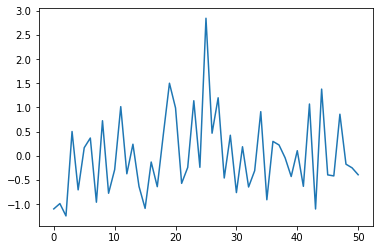

In [33]:
plt.plot(Y["score"]-Y["rating"])

WITH NON NMF l2 ERROR

Factorising Matrix-------steps:9 error:3.1397715444686543
Finished in 9.80338043700067 secs


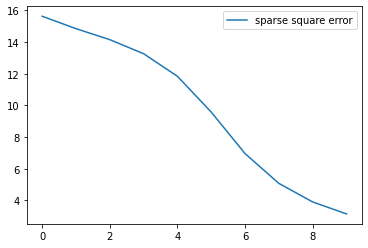

In [34]:
X=hpcpu.collaborative_filter(rating=rating,learn_rate=.001,dim=30,steps=10,user_id=12)

In [35]:
X=hpcpu.add_date(X,pd.DataFrame(item.iloc[:,0:2].values,columns=["item id","release"]),current_date=893286638)

In [36]:
Y=pd.merge(X,query[query["user id"]==12],how="inner",left_on="item id",right_on="item id")

In [37]:
X=hpcpu.add_weight(movie_age_weight_fit,X)

In [38]:
reco=hpcpu.recommendation(user_id=12,rank_matrix=X,query=query)
print("Movies you might want to watch",reco[0])
print("Old Movies you might want to watch",reco[1])
print("Trailers you might want to watch",reco[2])

Movies you might want to watch [234.0, 512.0, 419.0, 179.0, 423.0, 528.0, 186.0, 209.0, 710.0, 183.0]
Old Movies you might want to watch [675.0, 617.0, 1542.0]
Trailers you might want to watch [315.0, 1432.0]


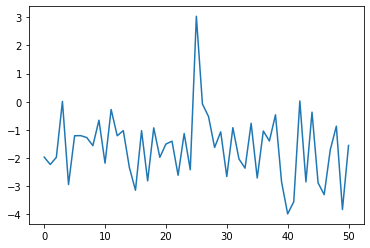

In [39]:
plt.plot(Y["score"]-Y["rating"])

WITH NON NMF Regularised SQ ERROR

Finished in 11.132269164001627 secsarse square error:3.9412965779021683 gravity:1.1140857904826467 regularisation:1.7800858569156994


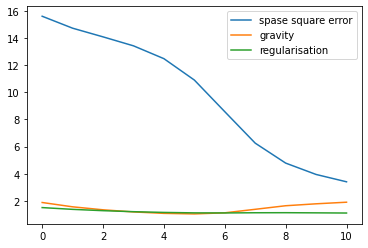

In [40]:
X=hpcpu.collaborative_filter_reg(rating=rating,learn_rate=50,gravity=1,weight=0.1,dim=30,steps=10,user_id=12)

In [41]:
X=hpcpu.add_date(X,pd.DataFrame(item.iloc[:,0:2].values,columns=["item id","release"]),current_date=893286638)

In [42]:
Y=pd.merge(X,query[query["user id"]==12],how="inner",left_on="item id",right_on="item id")

In [43]:
X=hpcpu.add_weight(movie_age_weight_fit,X)

In [44]:
reco=hpcpu.recommendation(user_id=12,rank_matrix=X,query=query)
print("Movies you might want to watch",reco[0])
print("Old Movies you might want to watch",reco[1])
print("Trailers you might want to watch",reco[2])

Movies you might want to watch [186.0, 517.0, 435.0, 527.0, 636.0, 208.0, 451.0, 177.0, 423.0, 357.0]
Old Movies you might want to watch [675.0, 1542.0, 617.0]
Trailers you might want to watch [315.0, 1432.0]


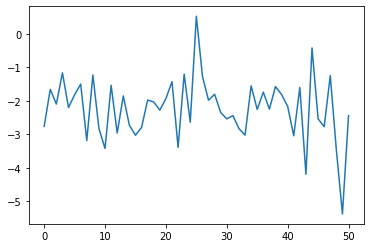

In [45]:
plt.plot(Y["score"]-Y["rating"])

# Feature Based Filtering

## Genre Based Filtering

WITH NMF l2 ERROR

In [46]:
genre_movie_embedding=item.iloc[:,2:]

Factorizing Matrix---------steps: 9 error: 6.7112421019190425
Finished in 10.128009169000507 secs, error: 6.7112421019190425


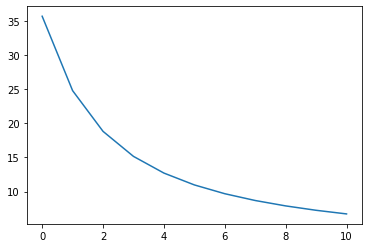

In [47]:
X=hpcpu.feature_filter_nmf(steps=10,rating=rating,feature_matrix=genre_movie_embedding.values,user_id=12,left=False,error_type="sq")

In [48]:
X=hpcpu.add_date(X,pd.DataFrame(item.iloc[:,0:2].values,columns=["item id","release"]),current_date=893286638)

In [49]:
Y=pd.merge(X,query[query["user id"]==12],how="inner",left_on="item id",right_on="item id")

In [50]:
X=hpcpu.add_weight(movie_age_weight_fit,X)

In [51]:
reco=hpcpu.recommendation(user_id=12,rank_matrix=X,query=query)
print("Movies you might want to watch",reco[0])
print("Old Movies you might want to watch",reco[1])
print("Trailers you might want to watch",reco[2])

Movies you might want to watch [654.0, 1091.0, 855.0, 1133.0, 142.0, 770.0, 101.0, 636.0, 135.0, 302.0]
Old Movies you might want to watch [675.0, 617.0, 1542.0]
Trailers you might want to watch [315.0, 1432.0]


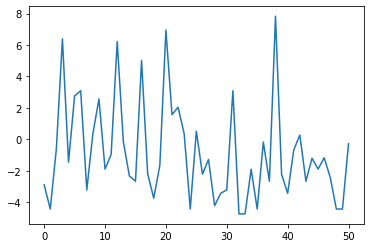

In [52]:
plt.plot(Y["score"]-Y["rating"])

WITH NMF KL ERROR

Finished in 11.690104089999295 secs error: 0.8031778534997421


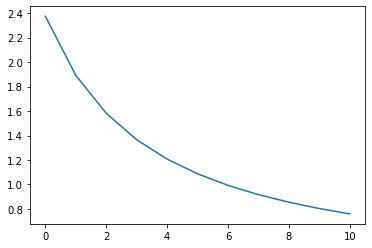

In [53]:
X=hpcpu.feature_filter_nmf(steps=10,rating=rating,feature_matrix=genre_movie_embedding.values,user_id=12,left=False,error_type="kl")

In [54]:
X=hpcpu.add_date(X,pd.DataFrame(item.iloc[:,0:2].values,columns=["item id","release"]),current_date=893286638)

In [55]:
Y=pd.merge(X,query[query["user id"]==12],how="inner",left_on="item id",right_on="item id")

In [56]:
X=hpcpu.add_weight(movie_age_weight_fit,X)

In [57]:
reco=hpcpu.recommendation(user_id=12,rank_matrix=X,query=query)
print("Movies you might want to watch",reco[0])
print("Old Movies you might want to watch",reco[1])
print("Trailers you might want to watch",reco[2])

Movies you might want to watch [426.0, 855.0, 183.0, 636.0, 101.0, 560.0, 423.0, 176.0, 1526.0, 164.0]
Old Movies you might want to watch [675.0, 617.0, 1542.0]
Trailers you might want to watch [315.0, 1432.0]


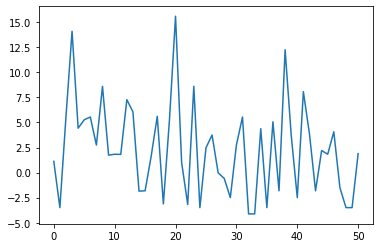

In [58]:
plt.plot(Y["score"]-Y["rating"])

WITH l2 NON NMF ERROR

Factorising Matrix-------steps:9 error:5.4036216789944765
Finished in 10.559093937001307 secs


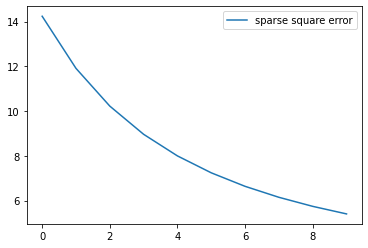

In [59]:
X=hpcpu.feature_filter(steps=10,learn_rate=.001,rating=rating,feature_matrix=genre_movie_embedding.values,user_id=12,left=False)

In [60]:
X=hpcpu.add_date(X,pd.DataFrame(item.iloc[:,0:2].values,columns=["item id","release"]),current_date=893286638)

In [61]:
Y=pd.merge(X,query[query["user id"]==12],how="inner",left_on="item id",right_on="item id")

In [62]:
X=hpcpu.add_weight(movie_age_weight_fit,X)

In [63]:
reco=hpcpu.recommendation(user_id=12,rank_matrix=X,query=query)
print("Movies you might want to watch",reco[0])
print("Old Movies you might want to watch",reco[1])
print("Trailers you might want to watch",reco[2])

Movies you might want to watch [855.0, 176.0, 636.0, 631.0, 1526.0, 173.0, 945.0, 135.0, 188.0, 207.0]
Old Movies you might want to watch [617.0, 1542.0, 675.0]
Trailers you might want to watch [315.0, 1432.0]


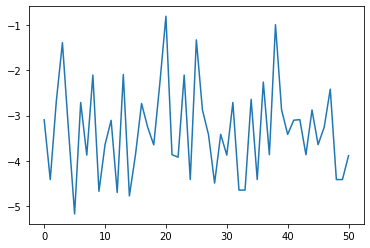

In [64]:
plt.plot(Y["score"]-Y["rating"])

WITH Regularised l2 NON NMF ERROR

Finished in 11.754961171000105 secsarse square error:8.764155763655882 gravity:0.666329886762224 regularisation:0.6617817435096477446


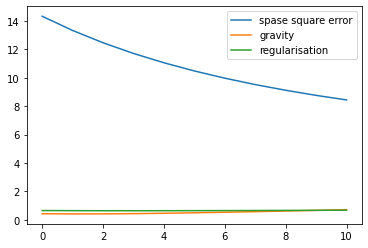

In [65]:
X=hpcpu.feature_filter_reg(steps=10,learn_rate=20,gravity=1,weight=.1,rating=rating,feature_matrix=genre_movie_embedding.values,user_id=12,left=False)

In [66]:
X=hpcpu.add_date(X,pd.DataFrame(item.iloc[:,0:2].values,columns=["item id","release"]),current_date=893286638)

In [67]:
Y=pd.merge(X,query[query["user id"]==12],how="inner",left_on="item id",right_on="item id")

In [68]:
X=hpcpu.add_weight(movie_age_weight_fit,X)

In [69]:
reco=hpcpu.recommendation(user_id=12,rank_matrix=X,query=query)
print("Movies you might want to watch",reco[0])
print("Old Movies you might want to watch",reco[1])
print("Trailers you might want to watch",reco[2])

Movies you might want to watch [855.0, 636.0, 135.0, 183.0, 164.0, 449.0, 654.0, 229.0, 1526.0, 230.0]
Old Movies you might want to watch [617.0, 1542.0, 675.0]
Trailers you might want to watch [315.0, 1432.0]


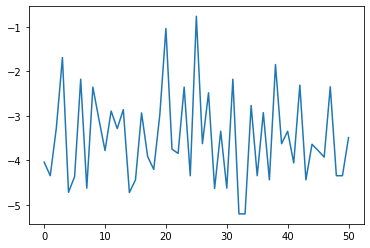

In [70]:
plt.plot(Y["score"]-Y["rating"])

## Occupation Based Filtering

WITH NMF l2 ERROR

In [71]:
user_occ=pd.DataFrame(user.iloc[:,3])

In [72]:
user_occ=hpcpu.vectorizer(user_occ,3)

Factorizing Matrix---------steps: 9 error: 1.6003337980037322
Finished in 10.297290619000705 secs, error: 1.600333798003732


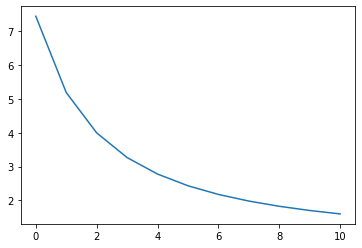

In [73]:
X=hpcpu.feature_filter_nmf(steps=10,rating=rating,feature_matrix=user_occ.values,user_id=12,left=True,error_type="sq")

In [74]:
X=hpcpu.add_date(X,pd.DataFrame(item.iloc[:,0:2].values,columns=["item id","release"]),current_date=893286638)

In [75]:
Y=pd.merge(X,query[query["user id"]==12],how="inner",left_on="item id",right_on="item id")

In [76]:
X=hpcpu.add_weight(movie_age_weight_fit,X)

In [77]:
reco=hpcpu.recommendation(user_id=12,rank_matrix=X,query=query)
print("Movies you might want to watch",reco[0])
print("Old Movies you might want to watch",reco[1])
print("Trailers you might want to watch",reco[2])

Movies you might want to watch [1583.0, 1005.0, 516.0, 638.0, 817.0, 442.0, 574.0, 1635.0, 1415.0, 1570.0]
Old Movies you might want to watch [675.0, 1542.0, 617.0]
Trailers you might want to watch [315.0, 1432.0]


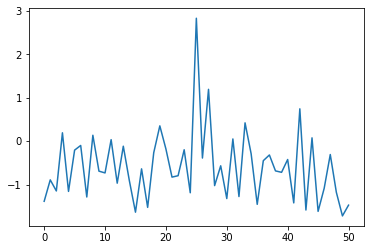

In [78]:
plt.plot(Y["score"]-Y["rating"])

WITH NMF KL ERROR

Finished in 11.22776899100063 secs9 error: 0.26283470294468255


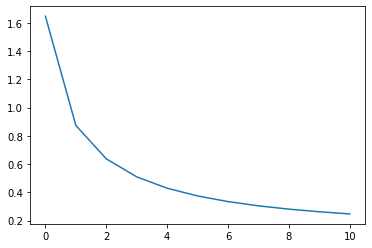

In [79]:
X=hpcpu.feature_filter_nmf(steps=10,rating=rating,feature_matrix=user_occ.values,user_id=12,left=True,error_type="kl")

In [80]:
X=hpcpu.add_date(X,pd.DataFrame(item.iloc[:,0:2].values,columns=["item id","release"]),current_date=893286638)

In [81]:
Y=pd.merge(X,query[query["user id"]==12],how="inner",left_on="item id",right_on="item id")

In [82]:
X=hpcpu.add_weight(movie_age_weight_fit,X)

In [83]:
reco=hpcpu.recommendation(user_id=12,rank_matrix=X,query=query)
print("Movies you might want to watch",reco[0])
print("Old Movies you might want to watch",reco[1])
print("Trailers you might want to watch",reco[2])

Movies you might want to watch [1301.0, 1560.0, 1526.0, 1656.0, 1411.0, 74.0, 1091.0, 448.0, 1065.0, 30.0]
Old Movies you might want to watch [617.0, 675.0, 1542.0]
Trailers you might want to watch [315.0, 1432.0]


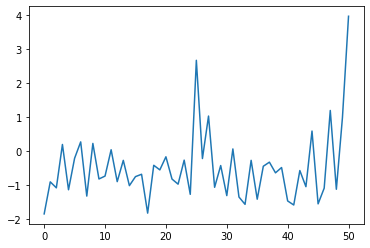

In [84]:
plt.plot(Y["score"]-Y["rating"])

WITH SQ ERROR NON NMF

Factorising Matrix-------steps:9 error:3.6111099701259692
Finished in 9.272777562000556 secs


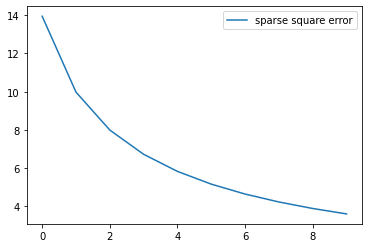

In [85]:
X=hpcpu.feature_filter(steps=10,rating=rating,learn_rate=.01,feature_matrix=user_occ.values,user_id=12,left=True)

In [86]:
X=hpcpu.add_date(X,pd.DataFrame(item.iloc[:,0:2].values,columns=["item id","release"]),current_date=893286638)

In [87]:
Y=pd.merge(X,query[query["user id"]==12],how="inner",left_on="item id",right_on="item id")

In [88]:
X=hpcpu.add_weight(movie_age_weight_fit,X)

In [89]:
reco=hpcpu.recommendation(user_id=12,rank_matrix=X,query=query)
print("Movies you might want to watch",reco[0])
print("Old Movies you might want to watch",reco[1])
print("Trailers you might want to watch",reco[2])

Movies you might want to watch [357.0, 423.0, 183.0, 234.0, 186.0, 521.0, 194.0, 187.0, 151.0, 180.0]
Old Movies you might want to watch [675.0, 1542.0, 617.0]
Trailers you might want to watch [315.0, 1432.0]


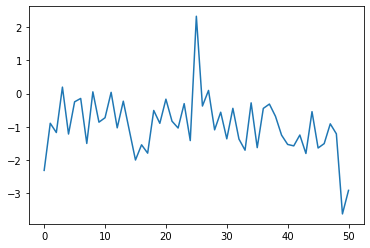

In [90]:
plt.plot(Y["score"]-Y["rating"])

WITH REGULARISED SQ ERROR NON NMF

Finished in 11.724270478000108 secsarse square error:12.412239801878751 gravity:0.6083526147739204 regularisation:0.24743865615141267


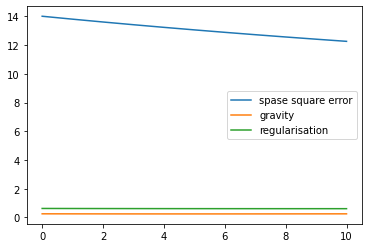

In [91]:
X=hpcpu.feature_filter_reg(steps=10,rating=rating,learn_rate=20,gravity=1,weight=.1,feature_matrix=user_occ.values,user_id=12,left=True)

In [92]:
X=hpcpu.add_date(X,pd.DataFrame(item.iloc[:,0:2].values,columns=["item id","release"]),current_date=893286638)

In [93]:
Y=pd.merge(X,query[query["user id"]==12],how="inner",left_on="item id",right_on="item id")

In [94]:
X=hpcpu.add_weight(movie_age_weight_fit,X)

In [95]:
reco=hpcpu.recommendation(user_id=12,rank_matrix=X,query=query)
print("Movies you might want to watch",reco[0])
print("Old Movies you might want to watch",reco[1])
print("Trailers you might want to watch",reco[2])

Movies you might want to watch [1526.0, 176.0, 183.0, 428.0, 1597.0, 616.0, 855.0, 822.0, 73.0, 65.0]
Old Movies you might want to watch [675.0, 617.0, 1542.0]
Trailers you might want to watch [315.0, 1432.0]


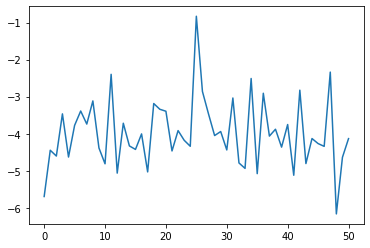

In [96]:
plt.plot(Y["score"]-Y["rating"])

## Age Based Filtering

In [97]:
user_age=pd.DataFrame(user.iloc[:,1])

In [98]:
user_age=hpcpu.vectorizer(user_age,1)

Factorizing Matrix---------steps: 9 error: 1.7197857952926854
Finished in 10.808348428001409 secs, error: 1.719785795292685


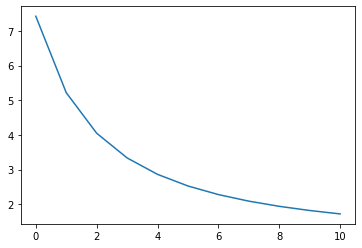

In [99]:
X=hpcpu.feature_filter_nmf(steps=10,rating=rating,feature_matrix=user_age.values,user_id=12,left=True,error_type="sq")

In [100]:
X=hpcpu.add_date(X,pd.DataFrame(item.iloc[:,0:2].values,columns=["item id","release"]),current_date=893286638)

In [101]:
Y=pd.merge(X,query[query["user id"]==12],how="inner",left_on="item id",right_on="item id")

In [102]:
X=hpcpu.add_weight(movie_age_weight_fit,X)

In [103]:
reco=hpcpu.recommendation(user_id=12,rank_matrix=X,query=query)
print("Movies you might want to watch",reco[0])
print("Old Movies you might want to watch",reco[1])
print("Trailers you might want to watch",reco[2])

Movies you might want to watch [1037.0, 1474.0, 646.0, 1444.0, 956.0, 691.0, 668.0, 415.0, 1556.0, 74.0]
Old Movies you might want to watch [675.0, 1542.0, 617.0]
Trailers you might want to watch [1432.0, 315.0]


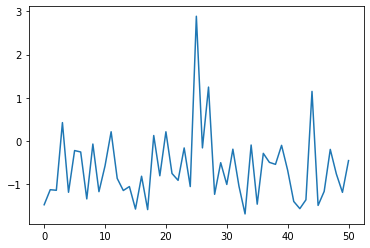

In [104]:
plt.plot(Y["score"]-Y["rating"])

WITH NMF KL ERROR

Finished in 11.086829221001608 secs error: 0.28051521880471146


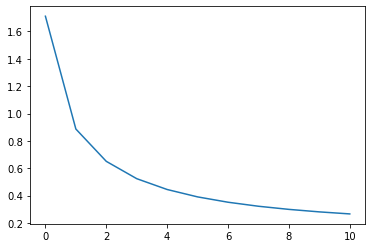

In [105]:
X=hpcpu.feature_filter_nmf(steps=10,rating=rating,feature_matrix=user_age.values,user_id=12,left=True,error_type="kl")

In [106]:
X=hpcpu.add_date(X,pd.DataFrame(item.iloc[:,0:2].values,columns=["item id","release"]),current_date=893286638)

In [107]:
Y=pd.merge(X,query[query["user id"]==12],how="inner",left_on="item id",right_on="item id")

In [108]:
X=hpcpu.add_weight(movie_age_weight_fit,X)

In [109]:
reco=hpcpu.recommendation(user_id=12,rank_matrix=X,query=query)
print("Movies you might want to watch",reco[0])
print("Old Movies you might want to watch",reco[1])
print("Trailers you might want to watch",reco[2])

Movies you might want to watch [1373.0, 1548.0, 1375.0, 1171.0, 795.0, 1100.0, 529.0, 1583.0, 1088.0, 1588.0]
Old Movies you might want to watch [617.0, 675.0, 1542.0]
Trailers you might want to watch [1432.0, 315.0]


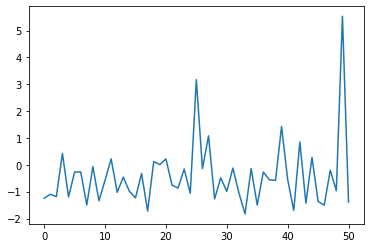

In [110]:
plt.plot(Y["score"]-Y["rating"])

WITH SQ ERROR NON NMF

Factorising Matrix-------steps:9 error:2.6661972322868272
Finished in 9.692186546999437 secs


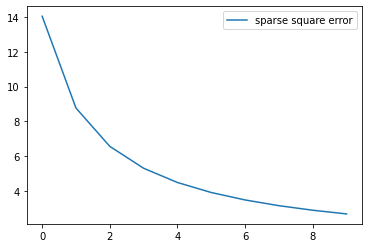

In [111]:
X=hpcpu.feature_filter(steps=10,rating=rating,learn_rate=.01,feature_matrix=user_age.values,user_id=12,left=True)

In [112]:
X=hpcpu.add_date(X,pd.DataFrame(item.iloc[:,0:2].values,columns=["item id","release"]),current_date=893286638)

In [113]:
Y=pd.merge(X,query[query["user id"]==12],how="inner",left_on="item id",right_on="item id")

In [114]:
X=hpcpu.add_weight(movie_age_weight_fit,X)

In [115]:
reco=hpcpu.recommendation(user_id=12,rank_matrix=X,query=query)
print("Movies you might want to watch",reco[0])
print("Old Movies you might want to watch",reco[1])
print("Trailers you might want to watch",reco[2])

Movies you might want to watch [357.0, 89.0, 183.0, 186.0, 208.0, 179.0, 180.0, 187.0, 194.0, 527.0]
Old Movies you might want to watch [675.0, 617.0, 1542.0]
Trailers you might want to watch [315.0, 1432.0]


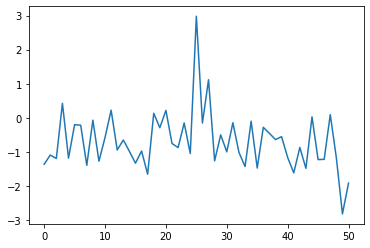

In [116]:
plt.plot(Y["score"]-Y["rating"])

WITH REGULARISED SQ ERROR NON NMF

Finished in 11.487817302000622 secsarse square error:11.894470687999025 gravity:0.4433005340833558 regularisation:0.252753063731767472


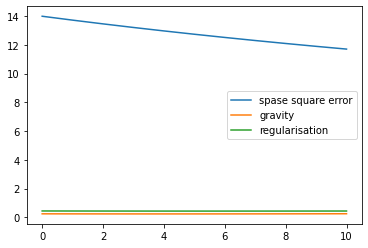

In [117]:
X=hpcpu.feature_filter_reg(steps=10,rating=rating,learn_rate=20,gravity=1,weight=.1,feature_matrix=user_age.values,user_id=12,left=True)

In [118]:
X=hpcpu.add_date(X,pd.DataFrame(item.iloc[:,0:2].values,columns=["item id","release"]),current_date=893286638)

In [119]:
Y=pd.merge(X,query[query["user id"]==12],how="inner",left_on="item id",right_on="item id")

In [120]:
X=hpcpu.add_weight(movie_age_weight_fit,X)

In [121]:
reco=hpcpu.recommendation(user_id=12,rank_matrix=X,query=query)
print("Movies you might want to watch",reco[0])
print("Old Movies you might want to watch",reco[1])
print("Trailers you might want to watch",reco[2])

Movies you might want to watch [89.0, 100.0, 151.0, 357.0, 205.0, 173.0, 211.0, 12.0, 56.0, 234.0]
Old Movies you might want to watch [617.0, 675.0, 1542.0]
Trailers you might want to watch [315.0, 1432.0]


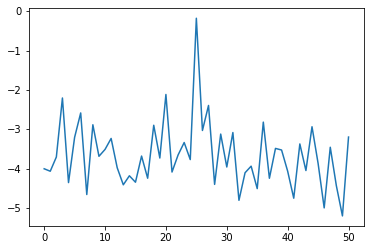

In [122]:
plt.plot(Y["score"]-Y["rating"])

## Location Based Filtering

In [123]:
user_loc=pd.DataFrame(user.iloc[:,5])

In [124]:
user_loc=hpcpu.vectorizer(user_loc,5)

Factorizing Matrix---------steps: 9 error: 1.3686013216219417
Finished in 10.905054479999308 secs, error: 1.3686013216219417


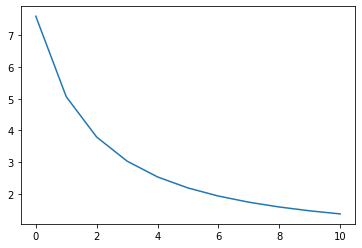

In [125]:
X=hpcpu.feature_filter_nmf(steps=10,rating=rating,feature_matrix=user_loc.values,user_id=12,left=True,error_type="sq")

In [126]:
X=hpcpu.add_date(X,pd.DataFrame(item.iloc[:,0:2].values,columns=["item id","release"]),current_date=893286638)

In [127]:
Y=pd.merge(X,query[query["user id"]==12],how="inner",left_on="item id",right_on="item id")

In [128]:
X=hpcpu.add_weight(movie_age_weight_fit,X)

In [129]:
reco=hpcpu.recommendation(user_id=12,rank_matrix=X,query=query)
print("Movies you might want to watch",reco[0])
print("Old Movies you might want to watch",reco[1])
print("Trailers you might want to watch",reco[2])

Movies you might want to watch [1571.0, 1616.0, 1198.0, 1460.0, 635.0, 1066.0, 1660.0, 1091.0, 35.0, 574.0]
Old Movies you might want to watch [617.0, 675.0, 1542.0]
Trailers you might want to watch [315.0, 1432.0]


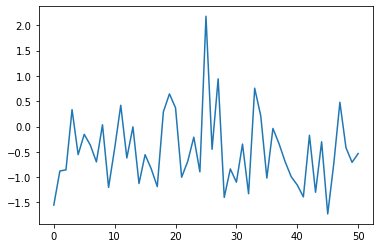

In [130]:
plt.plot(Y["score"]-Y["rating"])

WITH NMF KL ERROR

Finished in 11.252078790999803 secs error: 0.22047486566513325


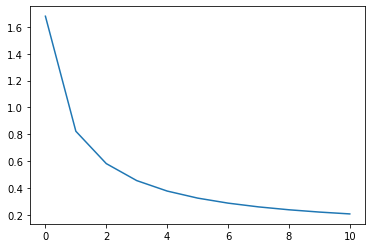

In [131]:
X=hpcpu.feature_filter_nmf(steps=10,rating=rating,feature_matrix=user_loc.values,user_id=12,left=True,error_type="kl")

In [132]:
X=hpcpu.add_date(X,pd.DataFrame(item.iloc[:,0:2].values,columns=["item id","release"]),current_date=893286638)

In [133]:
Y=pd.merge(X,query[query["user id"]==12],how="inner",left_on="item id",right_on="item id")

In [134]:
X=hpcpu.add_weight(movie_age_weight_fit,X)

In [135]:
reco=hpcpu.recommendation(user_id=12,rank_matrix=X,query=query)
print("Movies you might want to watch",reco[0])
print("Old Movies you might want to watch",reco[1])
print("Trailers you might want to watch",reco[2])

Movies you might want to watch [1118.0, 442.0, 1188.0, 635.0, 1267.0, 1487.0, 1411.0, 219.0, 1517.0, 861.0]
Old Movies you might want to watch [617.0, 675.0, 1542.0]
Trailers you might want to watch [1432.0, 315.0]


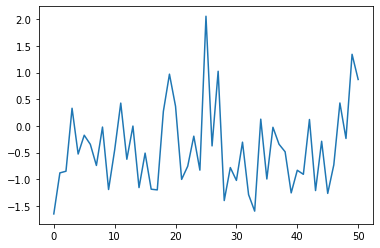

In [136]:
plt.plot(Y["score"]-Y["rating"])

WITH SQ ERROR NON NMF

Factorising Matrix-------steps:9 error:5.6952822216788985
Finished in 9.49796062600035 secs


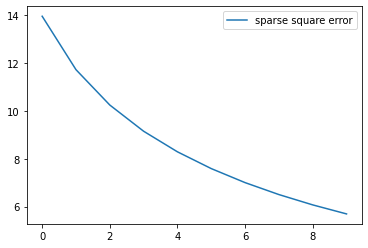

In [137]:
X=hpcpu.feature_filter(steps=10,rating=rating,learn_rate=.01,feature_matrix=user_loc.values,user_id=12,left=True)

In [138]:
X=hpcpu.add_date(X,pd.DataFrame(item.iloc[:,0:2].values,columns=["item id","release"]),current_date=893286638)

In [139]:
Y=pd.merge(X,query[query["user id"]==12],how="inner",left_on="item id",right_on="item id")

In [140]:
X=hpcpu.add_weight(movie_age_weight_fit,X)

In [141]:
reco=hpcpu.recommendation(user_id=12,rank_matrix=X,query=query)
print("Movies you might want to watch",reco[0])
print("Old Movies you might want to watch",reco[1])
print("Trailers you might want to watch",reco[2])

Movies you might want to watch [183.0, 205.0, 176.0, 423.0, 357.0, 194.0, 179.0, 654.0, 154.0, 89.0]
Old Movies you might want to watch [675.0, 1542.0, 617.0]
Trailers you might want to watch [315.0, 1432.0]


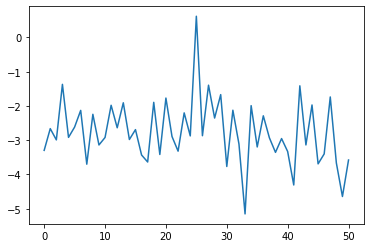

In [142]:
plt.plot(Y["score"]-Y["rating"])

WITH REGULARISED SQ ERROR NON NMF

Finished in 11.420678618998863 secsarse square error:13.171383610669334 gravity:1.391127061106352 regularisation:0.242630152815658066


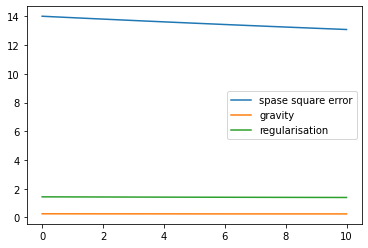

In [143]:
X=hpcpu.feature_filter_reg(steps=10,rating=rating,learn_rate=20,gravity=1,weight=.1,feature_matrix=user_loc.values,user_id=12,left=True)

In [144]:
X=hpcpu.add_date(X,pd.DataFrame(item.iloc[:,0:2].values,columns=["item id","release"]),current_date=893286638)

In [145]:
Y=pd.merge(X,query[query["user id"]==12],how="inner",left_on="item id",right_on="item id")

In [146]:
X=hpcpu.add_weight(movie_age_weight_fit,X)

In [147]:
reco=hpcpu.recommendation(user_id=12,rank_matrix=X,query=query)
print("Movies you might want to watch",reco[0])
print("Old Movies you might want to watch",reco[1])
print("Trailers you might want to watch",reco[2])

Movies you might want to watch [451.0, 219.0, 218.0, 1573.0, 415.0, 1118.0, 1411.0, 629.0, 206.0, 502.0]
Old Movies you might want to watch [617.0, 675.0, 1542.0]
Trailers you might want to watch [1432.0, 315.0]


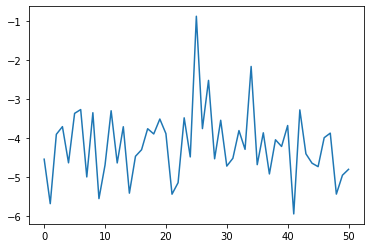

In [148]:
plt.plot(Y["score"]-Y["rating"])

# Web Scrapping Location

In [149]:
#state=[]
#i=0
#for x in user[4].values:
#    webadd="https://www.zipdatamaps.com/"+str(x)
#    print(i,end='\r')
#    i=i+1
#    r = requests.get(webadd)
#    soup = BeautifulSoup(r.content, 'html.parser')
#    s = soup.find('table', class_="table table-striped table-bordered table-hover table-condensed")
#    content = s.find_all('tr')
#    for line in content:
#        if "Zip Code State" in line.text:
#           # print(line.text[14:])
#            state.append(line.text[14:])
#            break
#user[5]=state
#del state
#user.to_csv(r"/home/avirup/Downloads/ml-100k/user_state.csv",index=False,header=False)